# Dependency Imports

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from collections import Counter
from wordcloud import WordCloud
import nltk
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model
from evaluate import load as load_metric

# Checking if `Hardware Acceleration` is available

In [2]:
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    tpu_available = True
except ImportError:
    tpu_available = False

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA) for computations.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS) for computations.")
elif tpu_available:
    device = xm.xla_device()
    print("Using TPU (XLA) for computations.")
else:
    device = torch.device("cpu")
    print("Neither CUDA, MPS, nor TPU available. Using CPU for computations.")

Using Apple Silicon GPU (MPS) for computations.


# Loading the Dataset

In [3]:
DATASET_PATH = 'Datasets/processed_final_195k.parquet'

In [4]:
df = pd.read_parquet(DATASET_PATH)
df.head()

,text_clean,label,text_clean_length,word_count_cleaned
0,que daora acho que meu ttulo foi cancelado,positive,42,8
1,ok je ferai cela aussi jaurai une lecture de l...,positive,76,18
2,mes cheveux sont loquents je me sens comme un ...,positive,91,18
3,yaaaa eu amo demais ver o seok se alimentando ...,negative,149,25
4,pourquoi pensezvous que vous avez vcu en austr...,negative,107,18


In [5]:
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nNull values:")
print(df.isnull().sum())

Dataset Shape: (194978, 4)

First 5 rows:
                                          text_clean     label  \
0         que daora acho que meu ttulo foi cancelado  positive   
1  ok je ferai cela aussi jaurai une lecture de l...  positive   
2  mes cheveux sont loquents je me sens comme un ...  positive   
3  yaaaa eu amo demais ver o seok se alimentando ...  negative   
4  pourquoi pensezvous que vous avez vcu en austr...  negative   

   text_clean_length  word_count_cleaned  
0                 42                   8  
1                 76                  18  
2                 91                  18  
3                149                  25  
4                107                  18  

Null values:
text_clean            0
label                 0
text_clean_length     0
word_count_cleaned    0
dtype: int64


In [6]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chyavanshenoy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chyavanshenoy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Cleanup

In [7]:
def clean_text_initial(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
df['text'] = df['text_clean'].fillna('').apply(clean_text_initial)

# Data Viz

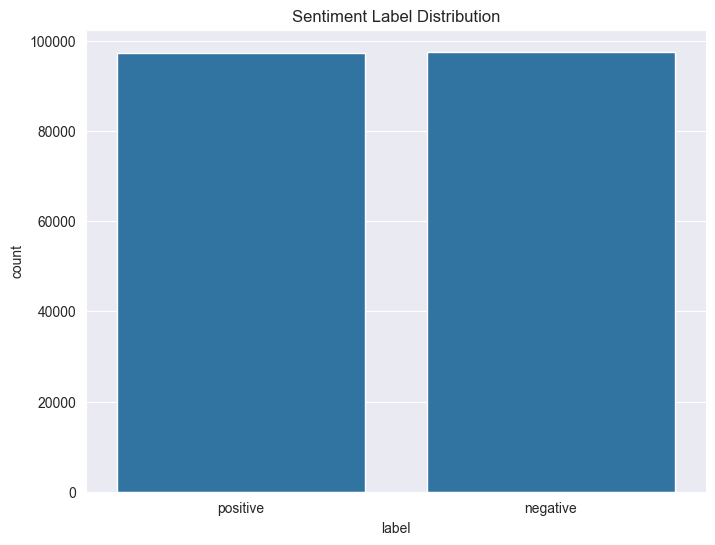

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Sentiment Label Distribution')
plt.show()

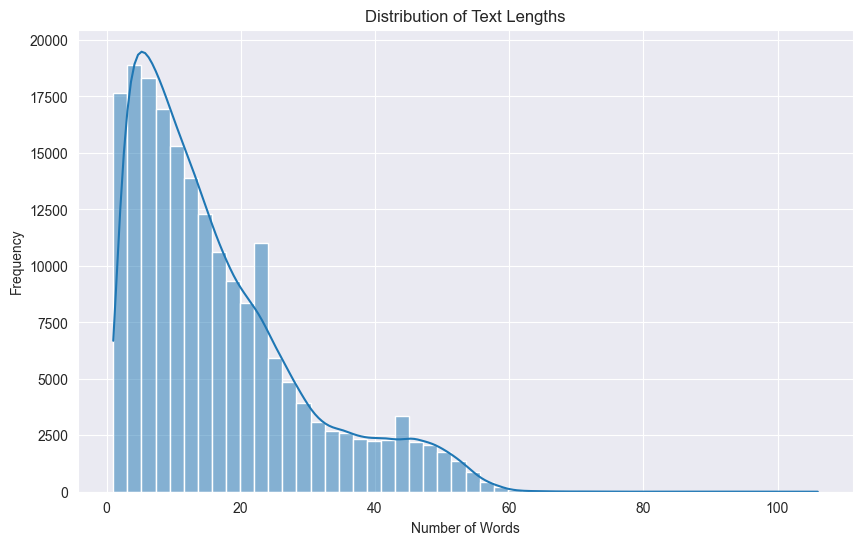

In [10]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

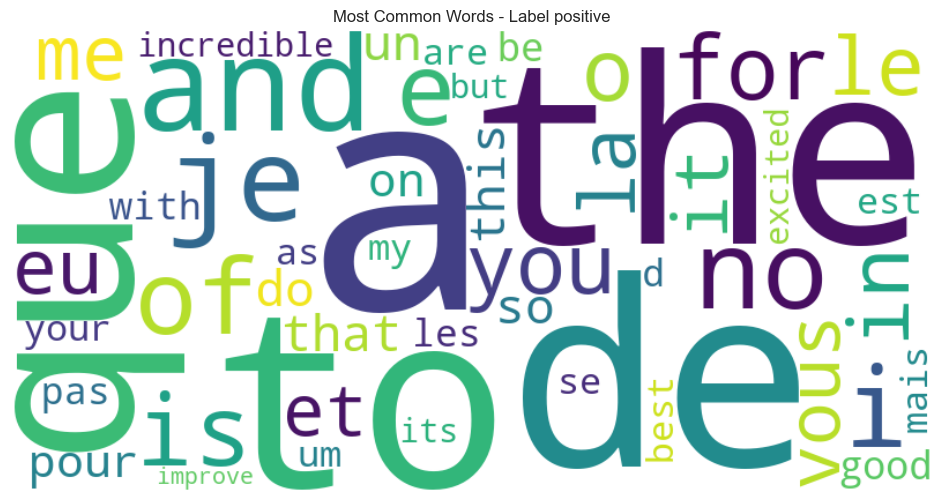

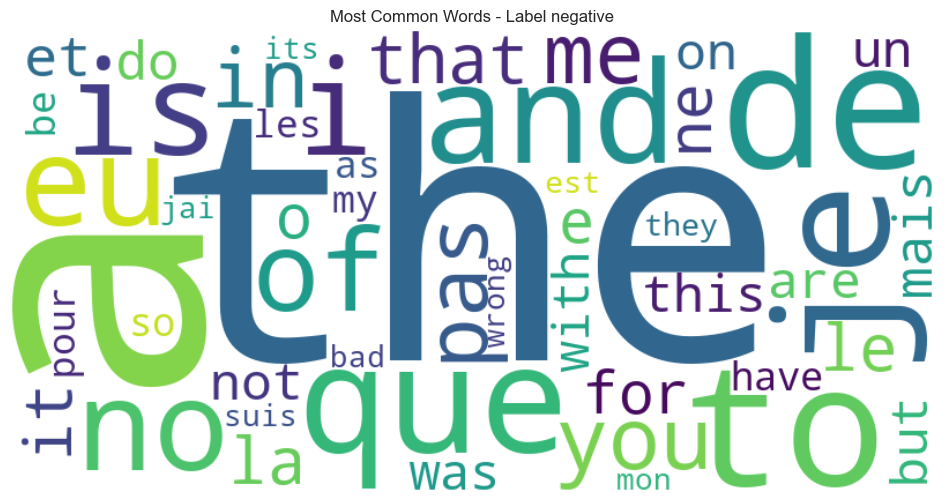

In [11]:
for label in df['label'].unique():
    subset = df[df['label'] == label]
    words = ' '.join(subset['text']).split()
    most_common = Counter(words).most_common(50)
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common))
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words - Label {label}')
    plt.show()

# Model Training

In [12]:
results = []

In [13]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label_encoded'], test_size=0.2, random_state=42, stratify=df['label_encoded'])


In [15]:
df.columns

Index(['text_clean', 'label', 'text_clean_length', 'word_count_cleaned',
       'text', 'text_length', 'label_encoded'],
      dtype='object')

### Logistic Regression with TF-IDF

In [16]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [20]:
print("Training Logistic Regression...")
log_reg = LogisticRegression(max_iter=3000)
log_reg.fit(X_train_vec, y_train)
y_pred_lr = log_reg.predict(X_test_vec)
report_lr = classification_report(y_test, y_pred_lr, target_names=le.classes_, output_dict=True)
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': report_lr['accuracy'],
    'Precision': report_lr['weighted avg']['precision'],
    'Recall': report_lr['weighted avg']['recall'],
    'F1-Score': report_lr['weighted avg']['f1-score']
})
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

Training Logistic Regression...


/Users/chyavanshenoy/Desktop/UniProjectGithub/AAI-510-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/chyavanshenoy/Desktop/UniProjectGithub/AAI-510-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/chyavanshenoy/Desktop/UniProjectGithub/AAI-510-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


Logistic Regression Report:
              precision    recall  f1-score   support

    negative       0.83      0.81      0.82     19516
    positive       0.82      0.84      0.83     19480

    accuracy                           0.82     38996
   macro avg       0.82      0.82      0.82     38996
weighted avg       0.82      0.82      0.82     38996



### Random Forest

In [21]:
print("\nTraining Random Forest...")
rf = RandomForestClassifier(n_estimators=200, random_state=42) # Using 100 estimators
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)
report_rf = classification_report(y_test, y_pred_rf, target_names=le.classes_, output_dict=True)
results.append({
    'Model': 'Random Forest',
    'Accuracy': report_rf['accuracy'],
    'Precision': report_rf['weighted avg']['precision'],
    'Recall': report_rf['weighted avg']['recall'],
    'F1-Score': report_rf['weighted avg']['f1-score']
})
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))


Training Random Forest...
Random Forest Report:
              precision    recall  f1-score   support

    negative       0.81      0.82      0.82     19516
    positive       0.82      0.81      0.81     19480

    accuracy                           0.82     38996
   macro avg       0.82      0.82      0.82     38996
weighted avg       0.82      0.82      0.82     38996



### LSTM

In [22]:
print("\nPreparing data for LSTM...")
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100


Preparing data for LSTM...


In [23]:
tokenizer_lstm = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_lstm.fit_on_texts(X_train)
X_train_seq = tokenizer_lstm.texts_to_sequences(X_train)
X_test_seq = tokenizer_lstm.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH) # Padding sequences
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [25]:
print("Building and Training LSTM model...")
model_lstm = Sequential([
    Embedding(MAX_NUM_WORDS, 128), # Embedding layer
    LSTM(128), # LSTM layer
    Dropout(0.5), # Dropout for regularization
    Dense(len(le.classes_), activation='softmax') # Output layer
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, verbose=2) # Training for 5 epochs

Building and Training LSTM model...
Epoch 1/10
4875/4875 - 68s - 14ms/step - accuracy: 0.8190 - loss: 0.3696 - val_accuracy: 0.8379 - val_loss: 0.3424
Epoch 2/10
4875/4875 - 69s - 14ms/step - accuracy: 0.8551 - loss: 0.3076 - val_accuracy: 0.8445 - val_loss: 0.3294
Epoch 3/10
4875/4875 - 70s - 14ms/step - accuracy: 0.8691 - loss: 0.2788 - val_accuracy: 0.8439 - val_loss: 0.3457
Epoch 4/10
4875/4875 - 68s - 14ms/step - accuracy: 0.8834 - loss: 0.2515 - val_accuracy: 0.8413 - val_loss: 0.3629
Epoch 5/10
4875/4875 - 69s - 14ms/step - accuracy: 0.8970 - loss: 0.2244 - val_accuracy: 0.8378 - val_loss: 0.3939
Epoch 6/10
4875/4875 - 71s - 15ms/step - accuracy: 0.9103 - loss: 0.1981 - val_accuracy: 0.8311 - val_loss: 0.4330
Epoch 7/10
4875/4875 - 70s - 14ms/step - accuracy: 0.9220 - loss: 0.1746 - val_accuracy: 0.8306 - val_loss: 0.4910
Epoch 8/10
4875/4875 - 69s - 14ms/step - accuracy: 0.9326 - loss: 0.1510 - val_accuracy: 0.8284 - val_loss: 0.5206
Epoch 9/10
4875/4875 - 69s - 14ms/step - acc

In [26]:
y_pred_lstm_prob = model_lstm.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)
report_lstm = classification_report(y_test, y_pred_lstm, target_names=le.classes_, output_dict=True)
results.append({
    'Model': 'LSTM',
    'Accuracy': report_lstm['accuracy'],
    'Precision': report_lstm['weighted avg']['precision'],
    'Recall': report_lstm['weighted avg']['recall'],
    'F1-Score': report_lstm['weighted avg']['f1-score']
})
print("\nLSTM Report:")
print(classification_report(y_test, y_pred_lstm, target_names=le.classes_))

1219/1219 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

LSTM Report:
              precision    recall  f1-score   support

    negative       0.83      0.82      0.82     19516
    positive       0.82      0.83      0.82     19480

    accuracy                           0.82     38996
   macro avg       0.82      0.82      0.82     38996
weighted avg       0.82      0.82      0.82     38996



### XLM RoBERTa

In [27]:
print("\nPreparing data for XLM-RoBERTa...")
# For XLM-R, we'll use the original labels as it handles strings
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])


Preparing data for XLM-RoBERTa...


In [28]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Define model ID and label mappings
MODEL_ID = "xlm-roberta-base"
LABEL2ID = {'negative': 0, 'positive': 1}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

In [29]:
tokenizer_xlm = AutoTokenizer.from_pretrained(MODEL_ID)

In [30]:
def tokenize_function(examples):
    # The tokenizer will handle converting labels to IDs
    return tokenizer_xlm(examples["text"], padding="max_length", truncation=True, max_length=128)

In [31]:
print("Tokenizing datasets...")
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Tokenizing datasets...


Map:   0%|          | 0/155982 [00:00<?, ? examples/s]

Map:   0%|          | 0/38996 [00:00<?, ? examples/s]

In [32]:
def map_labels(examples):
    examples['label'] = [LABEL2ID[lbl] for lbl in examples['label']]
    return examples

In [33]:
tokenized_train_dataset

Dataset({
    features: ['text_clean', 'label', 'text_clean_length', 'word_count_cleaned', 'text', 'text_length', 'label_encoded', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 155982
})

In [34]:
tokenized_test_dataset

Dataset({
    features: ['text_clean', 'label', 'text_clean_length', 'word_count_cleaned', 'text', 'text_length', 'label_encoded', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 38996
})

In [35]:
print("Mapping labels...")
tokenized_train_dataset = tokenized_train_dataset.map(map_labels, batched=True)
tokenized_test_dataset = tokenized_test_dataset.map(map_labels, batched=True) # <-- This is the corrected line

Mapping labels...


Map:   0%|          | 0/155982 [00:00<?, ? examples/s]

Map:   0%|          | 0/38996 [00:00<?, ? examples/s]

In [36]:
columns_to_remove = [
    'text_clean', 'text_clean_length', 'word_count_cleaned',
    'text', 'text_length', 'label_encoded', '__index_level_0__'
]

In [37]:
print("Removing unnecessary columns...")
tokenized_train_dataset = tokenized_train_dataset.remove_columns(
    [col for col in columns_to_remove if col in tokenized_train_dataset.column_names]
)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(
    [col for col in columns_to_remove if col in tokenized_test_dataset.column_names]
)


Removing unnecessary columns...


In [38]:
tokenized_train_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
print(f"Using device: {device}")

Using device: mps


In [40]:
model_xlm = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=len(ID2LABEL),
    id2label=ID2LABEL,
    label2id=LABEL2ID,
).to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
)

In [42]:
model_peft = get_peft_model(model_xlm, peft_config)
model_peft.print_trainable_parameters()

'NoneType' object has no attribute 'cadam32bit_grad_fp32'
trainable params: 1,181,954 || all params: 279,227,140 || trainable%: 0.4233


/Users/chyavanshenoy/Desktop/UniProjectGithub/AAI-510-Project/.venv/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [43]:
def compute_metrics(eval_pred):
    accuracy_metric = load_metric("accuracy")
    precision_metric = load_metric("precision")
    recall_metric = load_metric("recall")
    f1_metric = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        "accuracy": accuracy['accuracy'],
        "precision": precision['precision'],
        "recall": recall['recall'],
        "f1": f1['f1']
    }

In [44]:
training_args = TrainingArguments(
    output_dir="./xml_roberta_model",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=250,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True if torch.cuda.is_available() else False,
    report_to="none",
)

In [45]:
trainer = Trainer(
    model=model_peft,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer_xlm,
    compute_metrics=compute_metrics,
)

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_2990/3365558244.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [46]:
print("\nTraining XLM-RoBERTa with QLoRA...")
trainer.train()


Training XLM-RoBERTa with QLoRA...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.656200,0.566825,0.712996,0.715444,0.712996,0.712155
1000,0.560400,0.516954,0.739127,0.739234,0.739127,0.739102
1500,0.528000,0.498109,0.753231,0.754197,0.753231,0.753007
2000,0.514200,0.482075,0.765643,0.766018,0.765643,0.765566
2500,0.497200,0.466602,0.774592,0.774606,0.774592,0.774590
3000,0.482600,0.461084,0.777285,0.780558,0.777285,0.776618
3500,0.466000,0.440472,0.787953,0.788055,0.787953,0.787936
4000,0.457900,0.433641,0.789235,0.791232,0.789235,0.788862
4500,0.451800,0.423119,0.794235,0.794424,0.794235,0.794199
5000,0.445200,0.417239,0.799569,0.800353,0.799569,0.799432


TrainOutput(global_step=14625, training_loss=0.44540218177208535, metrics={'train_runtime': 6661.8523, 'train_samples_per_second': 70.243, 'train_steps_per_second': 2.195, 'total_flos': 3.120521509437235e+16, 'train_loss': 0.44540218177208535, 'epoch': 3.0})

In [47]:
print("\nEvaluating XLM-RoBERTa...")
eval_results = trainer.evaluate()
results.append({
    'Model': 'XLM-RoBERTa (QLoRA)',
    'Accuracy': eval_results['eval_accuracy'],
    'Precision': eval_results['eval_precision'],
    'Recall': eval_results['eval_recall'],
    'F1-Score': eval_results['eval_f1']
})


Evaluating XLM-RoBERTa...


### Lightweight BERT

In [60]:
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [61]:
model_name ="google/bert_uncased_L-4_H-256_A-4"

In [62]:
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)

In [67]:
train_ds_bert = Dataset.from_pandas(train_df[['text', 'label_encoded']].rename(columns={'label_encoded': 'labels'}))
test_ds_bert = Dataset.from_pandas(test_df[['text', 'label_encoded']].rename(columns={'label_encoded': 'labels'}))


In [68]:
def tokenize_bert(batch):
    return tokenizer_bert(batch["text"], truncation=True, padding="max_length", max_length=128)

In [69]:
print("Tokenizing datasets for BERT...")
train_ds_bert = train_ds_bert.map(tokenize_bert, batched=True, remove_columns=['text'])
test_ds_bert = test_ds_bert.map(tokenize_bert, batched=True, remove_columns=['text'])

Tokenizing datasets for BERT...


Map:   0%|          | 0/155982 [00:00<?, ? examples/s]

Map:   0%|          | 0/38996 [00:00<?, ? examples/s]

In [70]:
num_labels = len(df['label'].unique())
model_bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
def compute_metrics_bert(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}


In [90]:
training_args_bert = TrainingArguments( #
    output_dir='./results_bert', #
    num_train_epochs=3, #
    per_device_train_batch_size=128, #
    per_device_eval_batch_size=128, #
    warmup_steps=500, #
    weight_decay=0.01, #
    logging_dir='./logs_bert', #
    logging_steps=500, #
    eval_strategy="epoch", #
    save_strategy="epoch", #
    load_best_model_at_end=True, #
    metric_for_best_model="accuracy", #
    fp16=True if torch.cuda.is_available() else False, #
    report_to="none", #
)

In [91]:
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_ds_bert,
    eval_dataset=test_ds_bert,
    tokenizer=tokenizer_bert,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_bert),
    compute_metrics=compute_metrics_bert,
)

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_2990/4018880783.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


In [92]:
print("\nTraining Lightweight BERT...")
trainer_bert.train()


Training Lightweight BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.352800,0.339956,0.836317,0.836282,0.836626,0.836317
2,0.327600,0.330129,0.841830,0.841819,0.841911,0.841830
3,0.308300,0.330674,0.841830,0.841681,0.843074,0.841830


TrainOutput(global_step=3657, training_loss=0.32930989065944805, metrics={'train_runtime': 356.1854, 'train_samples_per_second': 1313.771, 'train_steps_per_second': 10.267, 'total_flos': 1159317003009024.0, 'train_loss': 0.32930989065944805, 'epoch': 3.0})

In [110]:
print("\nEvaluating Lightweight BERT...")
eval_results_bert = trainer_bert.evaluate() #
results.append({
    'Model': 'Lightweight BERT',
    'Accuracy': eval_results_bert['eval_accuracy'],
    'Precision': eval_results_bert['eval_precision'],
    'Recall': eval_results_bert['eval_recall'],
    'F1-Score': eval_results_bert['eval_f1']
})
print(f"Evaluation results: {eval_results_bert}")


Evaluating Lightweight BERT...
Evaluation results: {'eval_loss': 0.3301292657852173, 'eval_accuracy': 0.8418299312750026, 'eval_f1': 0.8418191797592368, 'eval_precision': 0.8419107721309642, 'eval_recall': 0.8418299312750026, 'eval_runtime': 9.9553, 'eval_samples_per_second': 3917.096, 'eval_steps_per_second': 30.637, 'epoch': 3.0}


# Visualizing the Results

In [111]:
results_df = pd.DataFrame(results)

In [112]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.824854,0.824995,0.824854,0.824837
1,Logistic Regression,0.824854,0.824995,0.824854,0.824837
2,Logistic Regression,0.824854,0.824995,0.824854,0.824837
3,Random Forest,0.815058,0.815061,0.815058,0.815057
4,LSTM,0.822187,0.822219,0.822187,0.822183
5,XLM-RoBERTa (QLoRA),0.821571,0.822368,0.821571,0.821456
6,Lightweight BERT,0.822315,0.825862,0.822315,0.821819
7,Lightweight BERT,0.841830,0.841911,0.841830,0.841819
8,Lightweight BERT,0.841830,0.841911,0.841830,0.841819


In [119]:
print("--- Model Performance Summary ---")
print(results_df.to_string(index=False))

--- Model Performance Summary ---
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.824854   0.824995 0.824854  0.824837
      Random Forest  0.815058   0.815061 0.815058  0.815057
               LSTM  0.822187   0.822219 0.822187  0.822183
XLM-RoBERTa (QLoRA)  0.821571   0.822368 0.821571  0.821456
   Lightweight BERT  0.841830   0.841911 0.841830  0.841819


In [120]:
plot_df = results_df.set_index('Model')

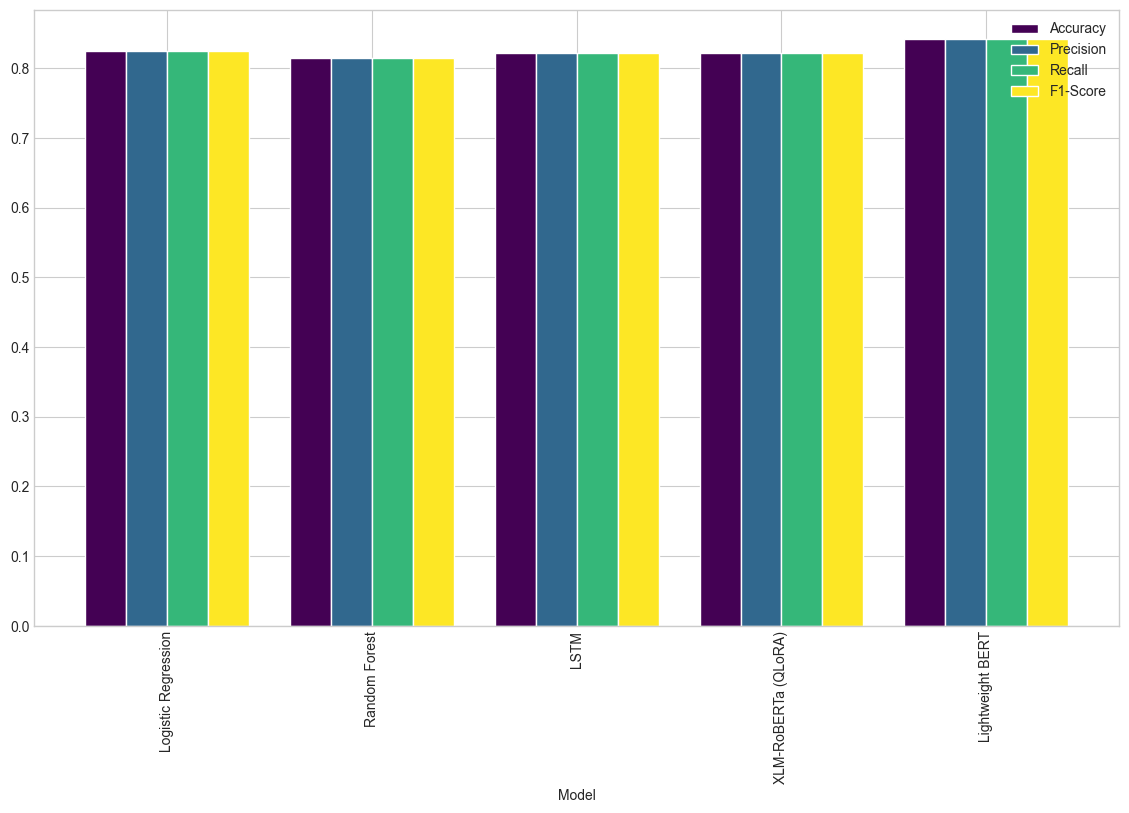

In [121]:
plt.style.use('seaborn-v0_8-whitegrid')
ax = plot_df.plot(
    kind='bar',
    figsize=(14, 8),
    width=0.8,
    colormap='viridis'
)

# Testing

In [122]:
import json
import numpy as np
import torch
from transformers import pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [123]:
test_samples_json = """
[
  {"text": "I love this product, it works perfectly!", "expected_label": "positive"},
  {"text": "Worst experience ever. Totally disappointed.", "expected_label": "negative"},
  {"text": "Ce produit est incroyable, je l'adore!", "expected_label": "positive"},
  {"text": "Très mauvaise qualité, je suis déçu.", "expected_label": "negative"},
  {"text": "Adorei este produto, funciona perfeitamente!", "expected_label": "positive"},
  {"text": "Não recomendo, péssima qualidade.", "expected_label": "negative"}
]
"""

In [124]:
test_samples = json.loads(test_samples_json)

In [125]:
bert_classifier = pipeline(
    "text-classification",
    model=trainer_bert.model,
    tokenizer=tokenizer_bert,
    device=device
)

Device set to use mps


In [126]:
bert_label_map = {"LABEL_0": "negative", "LABEL_1": "positive"}

In [127]:
xlmr_classifier = pipeline(
    "text-classification",
    model=trainer.model, # This is the PEFT model from the XLM-R training cell
    tokenizer=tokenizer_xlm,
    device=device
)

Device set to use mps


In [128]:
for i, sample in enumerate(test_samples):
    text = sample["text"]
    true_label = sample["expected_label"]

    print(f"\n--- Sample #{i+1} ---")
    print(f"Text: '{text}'")
    print(f"Expected Label: {true_label}")
    print("-" * 20)

    # --- a) Logistic Regression Prediction ---
    log_reg_vec = vectorizer.transform([text])
    log_reg_pred_prob = log_reg.predict_proba(log_reg_vec)[0]
    log_reg_pred_index = np.argmax(log_reg_pred_prob)
    log_reg_pred_label = le.inverse_transform([log_reg_pred_index])[0]
    log_reg_confidence = np.max(log_reg_pred_prob) * 100
    print(f"Logistic Regression -> Predicted: {log_reg_pred_label.capitalize()} ({log_reg_confidence:.2f}%)")

    # --- b) Random Forest Prediction ---
    rf_vec = vectorizer.transform([text])
    rf_pred_prob = rf.predict_proba(rf_vec)[0]
    rf_pred_index = np.argmax(rf_pred_prob)
    rf_pred_label = le.inverse_transform([rf_pred_index])[0]
    rf_confidence = np.max(rf_pred_prob) * 100
    print(f"Random Forest       -> Predicted: {rf_pred_label.capitalize()} ({rf_confidence:.2f}%)")

    # --- c) LSTM Prediction ---
    # Note: MAX_SEQUENCE_LENGTH should be the same as used in training (e.g., 100)
    lstm_seq = tokenizer_lstm.texts_to_sequences([text])
    lstm_padded_seq = pad_sequences(lstm_seq, maxlen=MAX_SEQUENCE_LENGTH)
    lstm_pred_prob = model_lstm.predict(lstm_padded_seq, verbose=0)[0]
    lstm_pred_index = np.argmax(lstm_pred_prob)
    lstm_pred_label = le.inverse_transform([lstm_pred_index])[0]
    lstm_confidence = np.max(lstm_pred_prob) * 100
    print(f"LSTM                -> Predicted: {lstm_pred_label.capitalize()} ({lstm_confidence:.2f}%)")

    # --- d) Lightweight BERT Prediction ---
    bert_prediction = bert_classifier(text)[0]
    bert_pred_label = bert_label_map.get(bert_prediction['label'], bert_prediction['label'])
    bert_confidence = bert_prediction['score'] * 100
    print(f"Lightweight BERT    -> Predicted: {bert_pred_label.capitalize()} ({bert_confidence:.2f}%)")

    # --- e) XLM-ROBERTa Prediction ---
    xlmr_prediction = xlmr_classifier(text)[0]
    xlmr_pred_label = xlmr_prediction['label']
    xlmr_confidence = xlmr_prediction['score'] * 100
    print(f"XLM-ROBERTa (QLORA) -> Predicted: {xlmr_pred_label.capitalize()} ({xlmr_confidence:.2f}%)")




--- Sample #1 ---
Text: 'I love this product, it works perfectly!'
Expected Label: positive
--------------------
Logistic Regression -> Predicted: Positive (80.93%)
Random Forest       -> Predicted: Positive (75.70%)
LSTM                -> Predicted: Positive (99.67%)
Lightweight BERT    -> Predicted: Positive (98.58%)
XLM-ROBERTa (QLORA) -> Predicted: Positive (99.76%)

--- Sample #2 ---
Text: 'Worst experience ever. Totally disappointed.'
Expected Label: negative
--------------------
Logistic Regression -> Predicted: Positive (71.15%)
Random Forest       -> Predicted: Positive (65.14%)
LSTM                -> Predicted: Negative (100.00%)
Lightweight BERT    -> Predicted: Positive (83.34%)
XLM-ROBERTa (QLORA) -> Predicted: Negative (98.87%)

--- Sample #3 ---
Text: 'Ce produit est incroyable, je l'adore!'
Expected Label: positive
--------------------
Logistic Regression -> Predicted: Positive (90.13%)
Random Forest       -> Predicted: Positive (77.88%)
LSTM                -> Predicte